In [ ]:
https://scikit-learn.org/stable/modules/mixture.html
https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_sin.html#sphx-glr-auto-examples-mixture-plot-gmm-sin-py
https://scikit-learn.org/stable/auto_examples/mixture/plot_concentration_prior.html#sphx-glr-auto-examples-mixture-plot-concentration-prior-py
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html#sklearn.mixture.BayesianGaussianMixture
https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py
https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html 
https://www.geeksforgeeks.org/ml-variational-bayesian-inference-for-gaussian-mixture/
    

'full' (each component has its own general covariance matrix),
'tied' (all components share the same general covariance matrix),
'diag' (each component has its own diagonal covariance matrix),
'spherical' (each component has its own single variance).

fnl_columns=pd.DataFrame(fnl_data.columns)
fnl_columns= fnl_columns.rename(columns={0:'Columns'})
fnl_columns['Check']=1
fnl_columns

data= pd.read_excel('/Users/aleksandr/Desktop/rpl_for_model.xlsx')

data_columns = pd.DataFrame(data.columns)
data_columns = data_columns.rename(columns={0:'Columns'})
data_columns
comparing = data_columns.merge(fnl_columns, how='left', on='Columns')
comparing

The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use. The AIC tells us that our choice of 16 components above was probably too many: around 8-12 components would have been a better choice. As is typical with this sort of problem, the BIC recommends a simpler model.

Notice the important point: this choice of number of components measures how well GMM works as a density estimator, not how well it works as a clustering algorithm. I'd encourage you to think of GMM primarily as a density estimator, and use it for clustering only when warranted within simple datasets.

In [173]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('classic')
import seaborn as sns; sns.set(style='white')
%matplotlib inline
from sklearn import decomposition
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
from gap_statistic import OptimalK
from datetime import datetime
from datetime import date


In [174]:
rpl_data= pd.read_excel('/Users/aleksandr/Desktop/rpl_for_model.xlsx')
fnl_general = pd.read_excel('/Users/aleksandr/Desktop/diplom/FNL_general.xlsx')
fnl_passing = pd.read_csv('/Users/aleksandr/Desktop/diplom/FNL_passing.csv')
fnl_data=fnl_general.merge(fnl_passing,how='left', on='Player')
data= rpl_data.append(fnl_data)

In [175]:
data=data.drop(['xG.1','xA per 90.1', 'xA.1'],axis=1)
data=data[data['Position']!='GK']
data=data[data['Market value']!=0]
player=data['Player']
target=data['Market value']
add_info=data[['Player', 'Market value', 'Team', 'Matches played', 'Minutes played', 'On loan']]
data=data.drop(['Player', 'Market value', 'Team', 'Matches played', 'Minutes played', 'On loan'],axis=1)

In [176]:
columns_names = []
for col in data.columns:
    columns_names.append(col)
    
cols_no_mean=['Position','Age', 'Contract expires', 'Birth country', 'Passport country', 'Foot', 'Height']
columns_names_mean= [x for x in columns_names if x not in cols_no_mean]
for i in data[columns_names_mean]:
    data[i] = data[i].fillna(data[i].mean(), inplace=False)
for i in data[cols_no_mean]:
    data[i] = data[i].fillna(0)    

In [177]:
network_metrics = data[['total_passes_closeness', 'total_passes_betw', 'total_passes_pagerank',
       'total_passes_transitivity', 'forward_passes_closeness',
       'forward_passes_betw', 'forward_passes_pagerank',
       'forward_passes_transitivity', 'back_passes_closeness',
       'back_passes_betw', 'back_passes_pagerank', 'back_passes_transitivity',
       'long_passes_closeness', 'long_passes_betw', 'long_passes_pagerank',
       'long_passes_transitivity', 'final_3rd_passes_closeness',
       'final_3rd_passes_betw', 'final_3rd_passes_pagerank',
       'final_3rd_passes_transitivity', 'progressive_passes_closeness',
       'progressive_passes_betw', 'progressive_passes_pagerank','progressive_passes_transitivity']]
#scaler = StandardScaler()
#scaler.fit(network_metrics)
#network_metrics_scaled = scaler.transform(network_metrics)
scaler = MinMaxScaler()  
scaler.fit(network_metrics)
network_metrics_scaled= scaler.transform(network_metrics)

In [178]:
#optimalK = OptimalK(parallel_backend='joblib')
#optimalK
#n_clusters = optimalK(network_metrics_scaled, cluster_array=np.arange(1, 30))

def optimalK(data, nrefs=5, maxClusters=30):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

In [179]:
k, gapdf = optimalK(network_metrics_scaled, nrefs=5, maxClusters=30)
print(k)

29


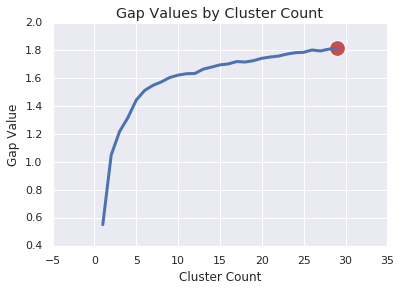

In [180]:
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.style.use('classic')
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

In [181]:
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=5, random_state=42)
roles_clusters= kmeans.fit_predict(network_metrics_scaled)
data['roles_clusters'] = roles_clusters
data = pd.get_dummies(data, columns=['roles_clusters'])

In [182]:
data=data.drop(['total_passes_closeness', 'total_passes_betw', 'total_passes_pagerank',
       'total_passes_transitivity', 'forward_passes_closeness',
       'forward_passes_betw', 'forward_passes_pagerank',
       'forward_passes_transitivity', 'back_passes_closeness',
       'back_passes_betw', 'back_passes_pagerank', 'back_passes_transitivity',
       'long_passes_closeness', 'long_passes_betw', 'long_passes_pagerank',
       'long_passes_transitivity', 'final_3rd_passes_closeness',
       'final_3rd_passes_betw', 'final_3rd_passes_pagerank',
       'final_3rd_passes_transitivity', 'progressive_passes_closeness',
       'progressive_passes_betw', 'progressive_passes_pagerank',
       'progressive_passes_transitivity'],axis=1)

In [183]:
data['shots on target per 90'] = data['Shots per 90'] * data['Shots on target %']
data['Dribbles succ. per 90'] = data['Dribbles per 90'] * data['Dribbles succ. %']
data['Def duels won per 90'] = data['Def duels per 90'] * data['Def duels won %']
data['Aerial duels won per 90'] = data['Aerial duels per 90'] * data['Aerial duels won %']
data['Tackle succ per 90'] = data['Tackles per 90'] * data['Tackle succ. %']
data['Smt passes acc. per 90'] = data['Smt passes per 90'] * data['Smt passes acc. %']
data['Final 3rd passes acc per90'] = data['Final 3rd passes per 90'] * data['Final 3rd passes acc. %']
data['Thru passes acc per 90'] = data['Thru passes per 90'] * data['Thru passes acc. %']
data['Deep completed passes acc per 90'] = data['Deep completed passes per 90'] * data['Deep completed passes acc. %']
data['Deep completed crosses acc per 90'] = data['Deep completed crosses per 90'] * data['Deep completed crosses acc. %']
data['Passes acc per 90'] = data['Passes per 90'] * data['Passes acc. %']
data['Fwd passes acc per 90'] = data['Fwd passes per 90'] * data['Fwd passes acc. %']
data['Back passes acc'] = data['Back passes per 90'] * data['Back passes acc. %']
data['Lat passes acc'] = data['Lat passes per 90'] * data['Lat passes acc. %']
data['Lng passes acc'] = data['Lng passes per 90'] * data['Lng passes acc. %']

In [184]:
data=data.drop(['Shots per 90','Shots on target %', 'Dribbles per 90', 'Dribbles succ. %',
               'Def duels per 90', 'Def duels won %','Aerial duels per 90','Aerial duels won %',
               'Tackles per 90', 'Tackle succ. %', 'Smt passes per 90', 'Smt passes acc. %', 'Final 3rd passes per 90',
               'Final 3rd passes acc. %','Thru passes per 90', 'Thru passes acc. %', 'Deep completed passes per 90', 
               'Deep completed passes acc. %','Deep completed crosses per 90',  'Deep completed crosses acc. %', 
               'Passes per 90','Passes acc. %','Fwd passes per 90',  'Fwd passes acc. %',  'Back passes per 90',
               'Back passes acc. %','Lat passes per 90', 'Lat passes acc. %','Lng passes per 90', 'Lng passes acc. %'],axis=1)

In [185]:
data['Contract expires'] = data['Contract expires'].replace(0,pd.to_datetime('today') )
data['Contract expires'] = pd.to_datetime(data['Contract expires'])
data['Contract length']= (data['Contract expires'] - pd.to_datetime('today')).astype('timedelta64[D]')
data['Contract length'] = data['Contract length'].replace(-1, 0)
data = data.drop(['Contract expires'],axis=1)

In [186]:
dropped_features = [['Fouls per 90', 'Yellow cards', 'Yellow cards per 90','Red cards', 'Height',
                'Weight','Non-penalty goals', 'Age', 'Goals total','Tackles per opp.30','Interceptions per opp.30',
               'Avg pass length. m', 'Avg lng pass length. m', 'Non-penalty goals per 90','Head goals total','Assists',
               'Shots total', 'xG', 'Red cards per 90', 'Succ. att. actions',
               'Goal conv.. %', 'xA', 'Crosses. %', 'Passes to penalty area acc. %',
               'Back passes acc', 'Lat passes acc', 'Lng passes acc', 'Contract length']]
data=data.drop(['Fouls per 90', 'Yellow cards', 'Yellow cards per 90','Red cards', 'Height',
                'Weight','Non-penalty goals', 'Age', 'Goals total','Tackles per opp.30','Interceptions per opp.30',
               'Avg pass length. m', 'Avg lng pass length. m', 'Non-penalty goals per 90','Head goals total','Assists',
               'Shots total', 'xG', 'Red cards per 90', 'Succ. att. actions',
               'Goal conv.. %', 'xA', 'Crosses. %', 'Passes to penalty area acc. %',
               'Back passes acc', 'Lat passes acc', 'Lng passes acc', 'Contract length'],axis=1)

In [187]:
def recode_nation(column):
    if column == 'Russia':
        return 1
    if column == 'Armenia':
        return 1
    if column == 'Kyrgyzstan':
        return 1
    if column == 'Kazakhstan':
        return 1
    if column == 'Ukraine':
        return 1
    else:
        return 0
    
    
data['Birth country'] =data['Birth country'].apply(recode_nation) 
data['Passport country'] =data['Passport country'].apply(recode_nation)
#data = pd.get_dummies(data, columns=['Position', 'Birth country', 'Passport country', 'Foot'])
data=data.drop(['Position'],axis=1)
#data = pd.get_dummies(data, columns=[ 'Birth country', 'Passport country', 'Foot'])
data=data.drop(['Birth country', 'Passport country', 'Foot'],axis=1)

In [188]:
data.head(1)

,Goals per 90,xG per 90,Head goals per 90,Assists per 90,xA per 90,Crosses per 90,Touches in box per 90,Progressive runs per 90,Succ. def. per 90,Shots blocked per 90,Interceptions per 90,Assists per 90.1,Second assists per 90,Third assists per 90,Key passes per 90,Passes to penalty area per 90,Progressive passes per 90,roles_clusters_0,roles_clusters_1,roles_clusters_2,roles_clusters_3,roles_clusters_4,roles_clusters_5,roles_clusters_6,roles_clusters_7,roles_clusters_8,roles_clusters_9,roles_clusters_10,roles_clusters_11,roles_clusters_12,roles_clusters_13,roles_clusters_14,roles_clusters_15,roles_clusters_16,roles_clusters_17,roles_clusters_18,roles_clusters_19,roles_clusters_20,roles_clusters_21,roles_clusters_22,roles_clusters_23,roles_clusters_24,roles_clusters_25,roles_clusters_26,roles_clusters_27,roles_clusters_28,shots on target per 90,Dribbles succ. per 90,Def duels won per 90,Aerial duels won per 90,Tackle succ per 90,Smt passes acc. per 90,Final 3rd passes acc per90,Thru passes acc per 90,Deep completed passes acc per 90,Deep completed crosses acc per 90,Passes acc per 90,Fwd passes acc per 90
0,0.0,0.99,0.0,0.0,0.06,0.0,4.09,1.02,3.07,0.0,0.0,0.0,0.0,0.0,0.0,1.02,2.05,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,102.25,306.6,613.5,102.2,0.0,0.0,0.0,0.0,0.0,0.0,1738.25,102.0


In [189]:
data.shape

(824, 58)

In [190]:
from sklearn import preprocessing
#scaler = MinMaxScaler()  
#scaler.fit(data)
#data_scaled= scaler.transform(data)

scaler = StandardScaler()
scaler.fit(data)
data_scaled = scaler.transform(data)

#data_scaled = preprocessing.Normalizer().fit(data)

In [191]:
k, gapdf = optimalK(data_scaled, nrefs=5, maxClusters=30)
print(k)

AttributeError: 'Normalizer' object has no attribute 'shape'

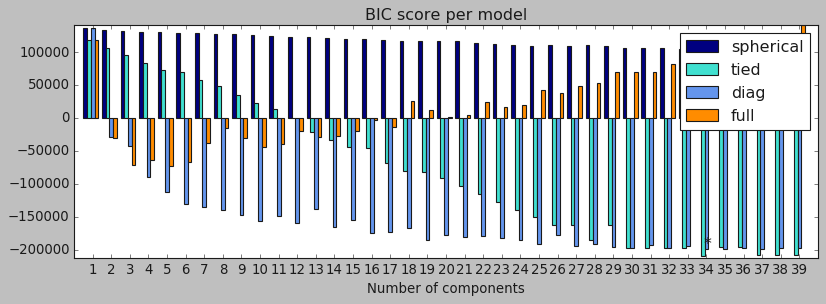

In [146]:
import numpy as np
import itertools
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import mixture
mpl.style.use('classic')



X = data_scaled
lowest_bic = np.infty
bic = []
n_components_range = range(1, 40)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(12, 8))
plt.grid(True)
plt.style.use('classic')
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)



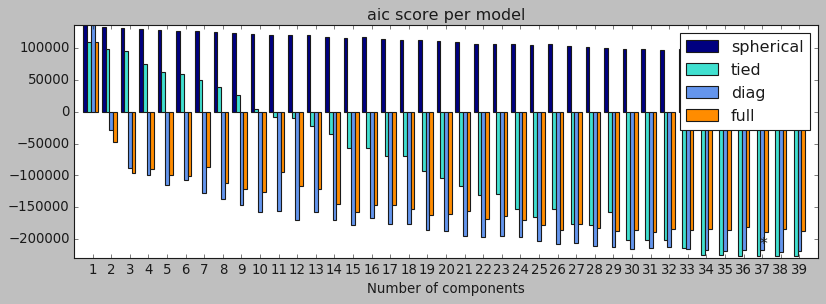

In [147]:
lowest_aic = np.infty
aic = []
n_components_range = range(1, 40)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        aic.append(gmm.aic(X))
        if aic[-1] < lowest_aic:
            lowest_aic = aic[-1]
            best_gmm = gmm

aic = np.array(aic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the aic scores
plt.figure(figsize=(12, 8))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, aic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([aic.min() * 1.01 - .01 * aic.max(), aic.max()])
plt.title('aic score per model')
xpos = np.mod(aic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(aic.argmin() / len(n_components_range))
plt.text(xpos, aic.min() * 0.97 + .03 * aic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)



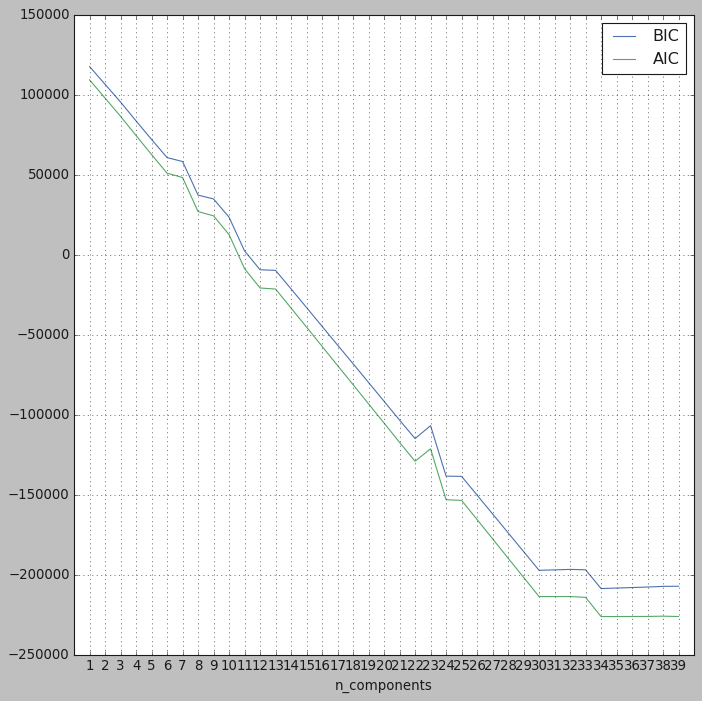

In [151]:
n_components = np.arange(1, 40)
models = [GaussianMixture(n, covariance_type='tied', random_state=42).fit(data_scaled) for n in n_components]
plt.figure(figsize=(10, 10))
plt.plot(n_components, [m.bic(data_scaled) for m in models], label='BIC')
plt.plot(n_components, [m.aic(data_scaled) for m in models], label='AIC')
plt.grid(True)
plt.style.use('classic')
plt.xticks(np.arange(1, 40))
plt.legend(loc='best')
plt.xlabel('n_components');

In [152]:
gmm = GaussianMixture(covariance_type='tied', n_components=34,max_iter=1000)
gmm.fit(data_scaled)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=1000,
        means_init=None, n_components=34, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [153]:
labels = gmm.predict_proba(data_scaled)

In [155]:
pd.DataFrame(labels).head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.014369e-177,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.983002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.016998,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.957621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.042379,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.183184e-178,0.000000,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.994493,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000e+00,0.000000,0.0
9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.0


In [87]:
from sklearn.mixture import BayesianGaussianMixture

In [156]:
GBM = BayesianGaussianMixture(n_components=34,  covariance_type='tied',weight_concentration_prior_type='dirichlet_process' )

In [157]:
GBM.fit(data_scaled)

BayesianGaussianMixture(covariance_prior=None, covariance_type='tied',
            degrees_of_freedom_prior=None, init_params='kmeans',
            max_iter=100, mean_precision_prior=None, mean_prior=None,
            n_components=34, n_init=1, random_state=None, reg_covar=1e-06,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_process')

In [158]:
labels = GBM.predict_proba(data_scaled)

In [159]:
pd.DataFrame(labels).head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,1.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00
1,0.0,0.0,1.250788e-163,9.653818e-317,0.0,0.0,0.0,0.0,2.536077e-302,0.0,0.0,0.0,9.655744e-111,0.0,0.0,0.0,0.0,0.0,0.0,3.292944e-268,0.0,0.0,0.0,0.0,1.681366e-316,0.0,1.000000e+00,0.0,0.0,0.0,0.0,6.558880e-304,0.0,7.123771e-195
2,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00
3,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,1.0,0.000000e+00
4,0.0,0.0,3.636816e-282,1.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,3.619130e-319,0.0,0.0,0.0,0.0,0.000000e+00,0.0,2.087477e-319,0.0,0.0,0.0,0.0,0.000000e+00,0.0,6.249269e-262
5,0.0,0.0,9.471787e-303,1.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,9.881313e-324,0.0,0.0,0.0,0.0,0.0,0.0,6.620480e-322,0.0,0.0,0.0,0.0,0.000000e+00,0.0,7.375412e-319,0.0,0.0,0.0,0.0,0.000000e+00,0.0,2.424678e-279
6,0.0,0.0,3.358341e-170,1.413028e-321,0.0,0.0,0.0,0.0,3.477325e-307,0.0,0.0,0.0,2.249587e-126,0.0,0.0,0.0,0.0,0.0,0.0,2.180413e-279,0.0,0.0,0.0,0.0,1.136351e-321,0.0,1.000000e+00,0.0,0.0,0.0,0.0,1.500143e-307,0.0,9.446714e-222
7,0.0,0.0,2.686854e-296,1.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,3.519692e-316,0.0,0.0,0.0,0.0,0.000000e+00,0.0,3.080618e-311,0.0,0.0,0.0,0.0,0.000000e+00,0.0,8.271498e-240
8,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,1.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00
9,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,1.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,5.928788e-323


In [160]:
X = data_scaled

In [161]:
BGM=(BayesianGaussianMixture(
        weight_concentration_prior_type="dirichlet_distribution",
        n_components=29, covariance_type='diag', reg_covar=0, init_params='random',
        max_iter=1500, mean_precision_prior=.8))

In [162]:
BGM.fit(data_scaled)

BayesianGaussianMixture(covariance_prior=None, covariance_type='diag',
            degrees_of_freedom_prior=None, init_params='random',
            max_iter=1500, mean_precision_prior=0.8, mean_prior=None,
            n_components=29, n_init=1, random_state=None, reg_covar=0,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_distribution')

In [163]:
BGM.predict(data_scaled)

array([22,  8, 17, 17,  8,  8,  8,  8, 11, 17, 17, 24,  8, 17, 17, 22,  8,
       11,  8,  8, 17,  8,  8, 12, 11, 17, 14, 17,  1, 17,  8, 22, 11, 17,
       12, 11, 17, 17,  8,  8,  8, 17, 22,  8,  8, 17, 14,  8, 17, 17, 17,
        8, 17, 17, 12, 12, 17, 25, 17,  8,  8, 17,  8,  8, 17, 17, 11, 17,
       17, 12,  5, 17, 17, 17, 17, 24, 12, 14, 17, 11,  8,  8, 17,  8, 17,
        8, 11,  8, 17, 17, 11, 17,  8, 17, 11,  8,  8,  8, 17, 17, 22, 17,
       17,  8, 12, 17, 12,  8, 17, 11, 17, 17,  8, 14, 11, 17,  8,  8, 17,
       22, 17, 17,  8, 17,  8, 17, 17, 17,  8, 17, 17, 14, 11, 17, 17, 17,
       17,  8, 17,  8, 17, 11, 14, 17,  8, 17,  8, 11, 17, 14, 17, 17,  8,
       17, 24, 17,  8,  8, 11, 17, 17, 17,  8, 17,  8, 17,  8, 17,  8, 17,
       17, 17, 17, 12, 17,  8, 17, 17, 11,  8, 11,  1, 17, 22,  8, 17,  8,
        8, 17, 17,  8, 14,  8, 17, 17, 17, 17,  8,  1, 17, 14, 17, 17,  1,
       17,  8, 17, 22, 11,  8, 17, 22, 17, 11, 14, 17,  5,  8, 17, 17, 14,
       17,  8,  8, 17, 17

In [164]:
BGM=    BayesianGaussianMixture(
        weight_concentration_prior_type="dirichlet_process",
        n_components=29, covariance_type='diag', reg_covar=0, init_params='random',
        max_iter=1500, mean_precision_prior=.8)

In [165]:
BGM.fit(data_scaled)

BayesianGaussianMixture(covariance_prior=None, covariance_type='diag',
            degrees_of_freedom_prior=None, init_params='random',
            max_iter=1500, mean_precision_prior=0.8, mean_prior=None,
            n_components=29, n_init=1, random_state=None, reg_covar=0,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_process')

In [166]:
BGM.predict(data_scaled)

array([13,  1,  1, 27,  1,  1,  1,  1, 13, 17,  1, 21,  1,  1, 13, 13,  1,
       13,  1,  1,  1,  1,  1, 13, 13, 17,  5,  1,  1, 27,  1, 13, 13,  1,
       13, 13, 17, 17,  1,  1,  1,  1, 13,  1,  1,  1,  5,  1, 17, 17, 13,
        1,  1, 27, 13, 13,  1, 15, 27,  1,  1, 27,  1,  1,  1, 17, 13,  1,
        1, 13, 13,  1, 17,  1,  1, 21, 13,  5,  1, 13,  1,  1, 27,  1,  1,
        1, 13,  1,  1,  1, 13,  1,  1,  1, 13,  1,  1,  1,  1,  1, 13,  1,
        1,  1, 13, 27, 13,  1,  1, 13, 17,  1,  1,  5, 13, 17,  1,  1, 17,
       13,  1, 17,  1, 17,  1, 17,  1, 27,  1, 27,  1,  5, 13, 27,  1, 27,
        1,  1, 17,  1, 27, 13, 18,  1,  1,  1,  1, 13,  1, 18, 17,  1,  1,
       27, 21,  1,  1,  1, 13,  1,  1,  1, 16,  1,  1, 17,  1, 17,  1,  1,
        1, 27,  1, 10, 17,  1,  1,  1, 13,  1, 13,  1, 27, 13,  1, 17,  1,
        1,  1,  1,  1,  5,  1, 27, 27, 13,  1,  1,  1, 17,  5,  1,  1,  1,
       27,  1, 27, 13, 13,  1,  1, 13,  1, 13,  5,  1, 13,  1,  1, 17,  5,
        1,  1,  1,  1, 17